# Walk through Variational Autoencoder (VAE)

In [1]:
import datetime
print(datetime.datetime.now().isoformat())

2019-05-11T16:13:36.256528


VAE is a generative model, which is trained on a training set and generates completely new data in evaluation. One popular example is generate new [MINIST hand-written digits](https://github.com/kvfrans/variational-autoencoder/blob/master/main.py). Here I am trying to demenstrate how this works with a simple example, and no Bayesian statistics needed. This article only offers intuition behind VAE. [This article](https://arxiv.org/pdf/1606.05908.pdf) includes all convinient details for better understanding.  

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

## Transformation of random variables
VAE use two nets, one for inference and one for genration. It plays with the back and forth mapping between training data and latent variables. Here we have to accept that our training data are actually samples from a complex space. For example, any picture in MNIST is just one of the unlimited ways to write a digit (if we don't argue that there are a limited number of pixels and grey map values has to be integer between 0-255). 
- Inference net: map a random training set data *X* to a random latent variable *z*.
- Genrative net: map a random latent variable *z* back to a training set data *X*.

In Carl's tutorial, there is one excellent example to see how mapping (or tranforming) random variables works in action. In the following code, *x* (left plot) stores 2D independent normal distribution samples (Isotropic Gaussian). By a simple transformation, $ y = f(x) = \frac{x}{||x||}$, we can see now *y* (right plot) is a distribution on a unit circle. Here we explicitly code f(x). VAE trains neural networks, and two of them.


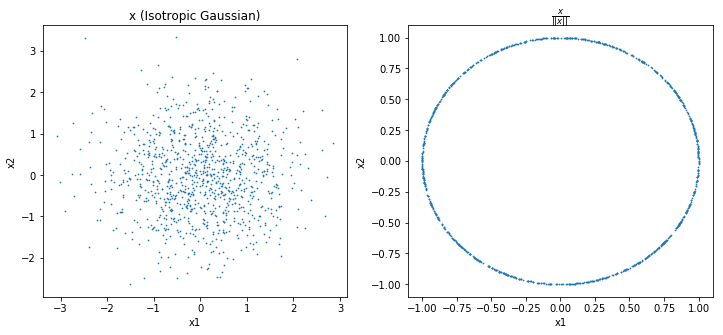

In [3]:
import torch
from torch import nn, optim
from torch.autograd import Variable

x = np.random.randn(1000,2)
x_abs = (x[:,0]**2+x[:,1]**2)**0.5
y = [x[:,0]/x_abs,x[:,1]/x_abs]
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.scatter(x[:,0],x[:,1],0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('x (Isotropic Gaussian)')
plt.subplot(122)
plt.scatter(y[0],y[1],0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(r'$\frac{x}{||x||}$');

## VAE model creation

Let's train the net with a simple task, to replicate data from another 2D Isotropic Gaussian with mean =(10,8) and a standard covariance matrix. In another word, shift the center of a standard Gaussian to (10,8). So the training set data would look like below, and *sample_real()* is kept as black box.


Text(0, 0.5, 'y1')

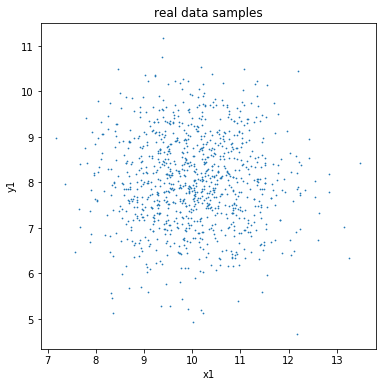

In [4]:
def sample_real(batch_size=100):
    x = torch.randn(batch_size,2)
    x[:,0] += 10
    x[:,1] += 8
    return x

plt.figure(figsize=[6,6])
x = sample_real(1000).numpy()
plt.scatter(x[:,0],x[:,1],0.5)
plt.title('real data samples')
plt.xlabel('x1')
plt.ylabel('y1')


Keep in mind that the inference model is needed for training purpose only. (This is similar to Generative Adversial Network(GAN), where the discriminative net is also only for training.) For mathematical convinience, there is an arbituary but well-accepted constraint added: **latent variables have to follow standard Isotropic Gassian distribution**, namely 

$N(\mu=[0]_n,\Sigma=I_{n\times n} )$.

Now have a look at the structure of encoder net and decoder net in the following Pytorch code.
- Encoder: takes training set data as input, and output latent variables in terms of mean $\mu$ and standard deviation $\Sigma$.
- Decoder: takes latent variables as inputs, by scaling a new standard Isotropic Gaussian random sample with respect to $\mu$ and $\Sigma$. And it tries to reproduce the training set data. The *decode()* function is used for new data generation, not in training.

*Why make the latent variable $z$ follow a standard Isotropic Gaussian?*
- Mathematical convinience (for KL Divergence)
- After training, sampling new latent variables = sampling standard Isotropic Gaussian. Super easy.

*Why is the latent variable $z$ disembled into $\mu$ and $\Sigma$? *
- It easy for regularization. Pushing $\mu \rightarrow 0$ and $\Sigma \rightarrow I$ would result in a standard Gaussian.
- ( The parameter trick. All net weights are isolated from the random Gaussian sampling. Easy backpropagation.)


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Build two layer net
        self.linear1 = nn.Sequential(nn.Linear(2,8),nn.ELU())
        self.linear_mu = nn.Linear(8,8)
        self.linear_std = nn.Linear(8,8)
        self._init_parameters()
        
    def forward(self, input):
        output = self.linear1(input)
        mu = self.linear_mu(output)
        std = self.linear_std(output)
        return mu, std
    
    def _init_parameters(self):
        for p in self.parameters():
            if p.ndimension()>1:
                nn.init.kaiming_normal(p)

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(8,8),nn.ELU())
        self.linear2 = nn.Linear(8,2)
        self._init_parameters()
    def forward(self, mu, std):
        output = Variable(torch.randn(mu.size()))
        output = mu + output*std
        output = self.linear1(output)
        output = self.linear2(output)
        return output
    def _init_parameters(self):
        for p in self.parameters():
            if p.ndimension()>1:
                nn.init.kaiming_normal(p)
    def decode(self,z):
        output = self.linear1(z)
        output = self.linear2(output)
        return output

## Loss function

We can avoid the math here, but still just have a glance at the original loss function.

$E_{z~Q}[log_P{X|z}] + D_{KL}[{Q(z|x)}||{P(z)}]$.

Now forget the equation and focus on the logic.
- loss = reconstruction_loss + latent_loss
- reconstruction_loss = X_generated should equal X => MSE, Regression, or whatever
- latent_loss = drive $\mu$ and $\Sigma$ toward an Isotropic Gaussian => how about $\mu^2 +  tr \Sigma$

If we are not a strict Bayesianist, we do not have to follow the loss function in paper, because the simple ones will do as well.

Let's take a look at kvfran's code. The reconstruction loss = $-x\cdot \log{x_{generated}} - (1-x)\cdot \log{1-x_{generated}}$. And it's derivative is

$\frac{\partial{LOSS}}{\partial{x_{generated}}} =\frac{x}{x_{generated}}+\frac{(1-x)}{1-x_{generated}}$

It equals zero only when $x$ equals $x_{generated}$. No better than MSE loss, the same global minimum. And I do not have to confine the output to $[0,1]$ with MSE.

Text(0.5, 1.0, 'LOSS used in paper (x_{t}=0.4)')

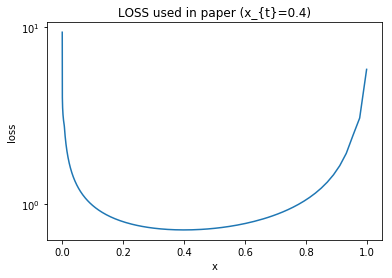

In [7]:
# Check minimum of reconstruction loss
xs = np.linspace(-10,-0.0001,1000)
xs = 10**xs
xt = 0.4
ax, = plt.plot(xs, -xt*np.log(xs)-(1-xt)*np.log(1-xs))
plt.gca().set_yscale('symlog')
plt.xlabel('x')
plt.ylabel('loss')
plt.title('LOSS used in paper (x_{t}=0.4)')

The same goes for the latent loss. The function in paper is just a fancy to to say $\mu = [0]_n$ and $\Sigma = I_{n\times n}$ at global minimum, because KL divergence is always positive otherwise. This means L1, L2 regularization would do as well. (Compared with GAN, we can also optimize inference net and genrative net seperately, as long as weights converge.

Text(0.5, 1.0, '$\\Sigma$ loss part\n $\\sigma^2 - log(\\sigma^2) -1$')

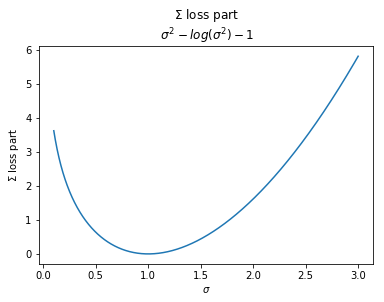

In [8]:
# Check minimum of Sigma
xs = np.linspace(1e-1,3,1000)
plt.plot(xs, xs**2-1-2*np.log(xs))
plt.xlabel('$\sigma$')
plt.ylabel('$\Sigma$ loss part')
plt.title('$\Sigma$ loss part\n $\sigma^2 - log(\sigma^2) -1$')

## Actual training

During the training, we can see the genrative data floating gradually toward training set data, like in my post for GAN.

In [9]:
# a helper function to plot results
def plot_decoder():
    z = Variable(torch.randn(200,8))
    x_gen = decoder.decode(z).data.numpy()
    plt.figure(figsize=[5,5])
    plt.scatter(x_gen[:,0],x_gen[:,1],0.8)
    x_real = sample_real(200).numpy()
    plt.scatter(x_real[:,0],x_real[:,1],0.8)
    plt.legend(['VAE','Real Data'])
    plt.xlim([-1,11])
    plt.ylim([-1,11])

In [10]:
from itertools import chain
learning_rate = 0.0001
max_epoch = 100001
batch_size = 200

encoder = Encoder()
decoder = Decoder()

parameters = chain(encoder.parameters(), decoder.parameters())
optimizer = optim.Adam(parameters,lr=learning_rate)

for epoch in range(max_epoch):
    optimizer.zero_grad()
    x = Variable(sample_real(batch_size))
    mu, std = encoder(x)
    x_gen = decoder(mu,std)
    loss_reconstruction = torch.mean((x_gen-x)**2)
    D_kl = 0.5*torch.mean(mu**2 + std**2 - 1 - 2*torch.log(1e-10+torch.abs(std)))
    loss = loss_reconstruction + D_kl
    loss.backward()
    optimizer.step()
    if epoch%1000==0:
        print('epoch={}, loss={}'.format(epoch,loss.data.numpy()[0]))
    if epoch%10000==0:
        plot_decoder()
    plt.show()
        
    

/home/rashed/.local/share/virtualenvs/NeuralNetwork-jO0n7Plv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/home/rashed/.local/share/virtualenvs/NeuralNetwork-jO0n7Plv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  app.launch_new_instance()


IndexError: too many indices for array

## Conclusion

I think neural network would be the new toy for stastistians, as a omiponent and versatile function. The success of VAE (and Reinfocement net) really has a deep root in statistics. Time to pick it up.